In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-04-21 19:21:59.972693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')
        x_min = int(xmlbox.find('xmin').text)
        y_min = int(xmlbox.find('ymin').text)
        x_max = int(xmlbox.find('xmax').text)
        y_max = int(xmlbox.find('ymax').text)
        return filename, (x_min, y_min, x_max, y_max)

def load_data(image_directory, annotations_directory, target_size=(224, 224)):
    images = []
    boxes = []
    filenames = []

    for xml_file in os.listdir(annotations_directory):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_directory, xml_file)
            filename, bbox = parse_annotation(xml_path)

            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            h, w, _ = img.shape
            img = cv2.resize(img, target_size)  # Resize image to ensure consistency

            # Ensure bounding box is normalized and in the correct shape
            # h, w, _ = img.shape
            # w, h = target_size
            # print(bbox)
            normalized_bbox = [
                bbox[0] / w, 
                bbox[1] / h, 
                bbox[2] / w, 
                bbox[3] / h
            ]
            # print(normalized_bbox)
            
            images.append(img)
            boxes.append(normalized_bbox)
            filenames.append(filename)

    return np.array(images), np.array(boxes), np.array(filenames)

In [36]:
# Paths to your dataset
image_directory = 'archive/images'
annotations_directory = 'archive/annotations'

images, boxes, filenames = load_data(image_directory, annotations_directory)
print(images[:5])
print(boxes[:5])
print(filenames[:5])

[[[[172 178 174]
   [172 179 175]
   [172 178 175]
   ...
   [100 105 104]
   [111 116 112]
   [110 116 112]]

  [[170 176 172]
   [169 176 173]
   [169 176 173]
   ...
   [102 107 106]
   [110 115 112]
   [111 116 113]]

  [[169 176 172]
   [166 175 171]
   [170 177 174]
   ...
   [105 110 108]
   [110 115 111]
   [113 117 114]]

  ...

  [[ 43  42  38]
   [ 45  44  42]
   [ 43  43  40]
   ...
   [ 64  65  64]
   [ 64  65  64]
   [ 63  65  65]]

  [[ 43  43  40]
   [ 44  44  41]
   [ 44  43  40]
   ...
   [ 61  63  62]
   [ 62  63  63]
   [ 63  65  64]]

  [[ 40  41  37]
   [ 40  41  38]
   [ 38  38  36]
   ...
   [ 62  64  63]
   [ 64  65  64]
   [ 64  65  64]]]


 [[[252 249 251]
   [249 249 254]
   [248 251 255]
   ...
   [120 121 118]
   [227 231 231]
   [243 250 252]]

  [[254 254 249]
   [251 255 252]
   [245 251 251]
   ...
   [ 21  22  19]
   [213 218 217]
   [246 251 252]]

  [[252 255 245]
   [247 254 244]
   [240 247 238]
   ...
   [ 19  19  13]
   [227 231 228]
   [243 248

In [37]:
def get_image_dimensions(annotation_directory):
    dimensions = {}
    for xml_file in os.listdir(annotation_directory):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotation_directory, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            dimensions[filename] = (width, height)
    return dimensions

In [38]:
annotation_directory = 'archive/annotations'
image_dimensions = get_image_dimensions(annotation_directory)

In [39]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Predict bounding boxes on the test set
# predictions = model.predict(X_test)

def draw_box(img, box, color, label):
    print(box)
    """
    Draw a bounding box on an image with a label at the top-left corner.
    """
    # Draw the bounding box
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
    # Draw the label
    cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Adapt the plotting function to work with non-normalized coordinates
def plot_image_with_bbox(img, box, pred_box):
    # Draw the true and predicted boxes
    box = box[1]
    #pred_box = pred_box[1]

    draw_box(img, (int(box[0]), int(box[1]), int(box[2]), int(box[3])), (0, 255, 0), "True Box")
    draw_box(img, (int(pred_box[0]), int(pred_box[1]), int(pred_box[2]), int(pred_box[3])), (255, 0, 0), "Predicted Box")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('True vs Predicted Bounding Box')
    plt.show()



In [40]:
imgs = images[:5]
bxs = boxes[:5]
fls = filenames[:5]

In [41]:
def denormalize_predictions_2(predictions, filenames, image_dimensions):
    denormalized_boxes = []
    print(predictions[:5])
    for filename, box in zip(filenames, predictions):
        #print(filename)
        if filename in image_dimensions:
            width, height = image_dimensions[filename]
            x_min, y_min, x_max, y_max = box
            x_min = int(x_min * 224)
            y_min = int(y_min * 224)
            x_max = int(x_max * 224)
            y_max = int(y_max * 224)
            denormalized_boxes.append((filename, (x_min, y_min, x_max, y_max)))
        else:
            print(f"Dimensions not found for {filename}")
    return denormalized_boxes

In [42]:
denorm_box = denormalize_predictions_2(bxs, fls, image_dimensions)

[[0.375      0.53333333 0.5825     0.64666667]
 [0.635      0.4790795  0.93       0.55230126]
 [0.18       0.46333333 0.49       0.74      ]
 [0.49777778 0.53846154 0.84888889 0.74247492]
 [0.395      0.74333333 0.595      0.8       ]]


In [43]:
print(denorm_box)

[('Cars213.png', (84, 119, 130, 144)), ('Cars207.png', (142, 107, 208, 123)), ('Cars398.png', (40, 103, 109, 165)), ('Cars367.png', (111, 120, 190, 166)), ('Cars401.png', (88, 166, 133, 179))]


(84, 119, 130, 144)
(0, 0, 0, 0)


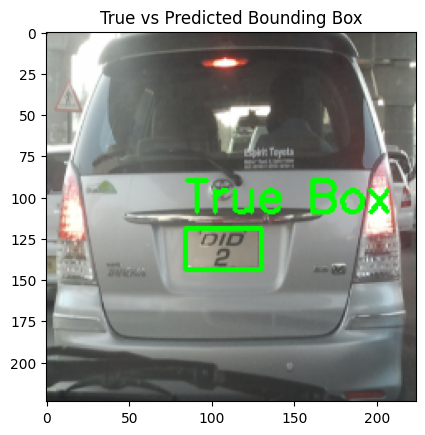

(142, 107, 208, 123)
(0, 0, 0, 0)


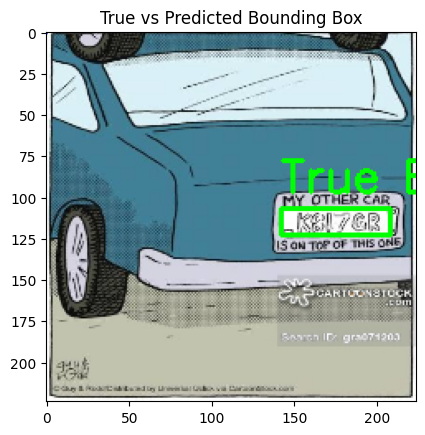

(40, 103, 109, 165)
(0, 0, 0, 0)


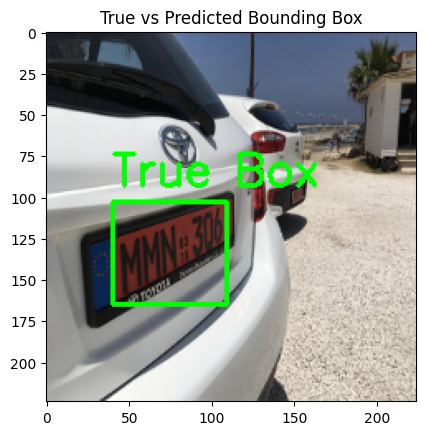

(111, 120, 190, 166)
(0, 0, 0, 0)


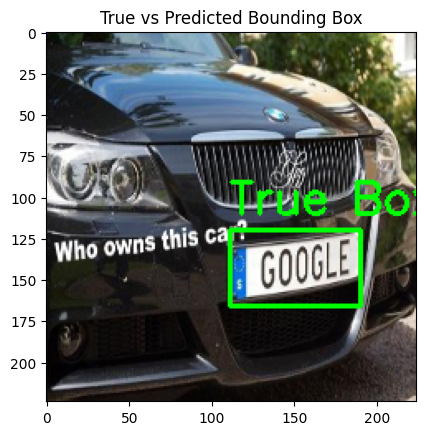

(88, 166, 133, 179)
(0, 0, 0, 0)


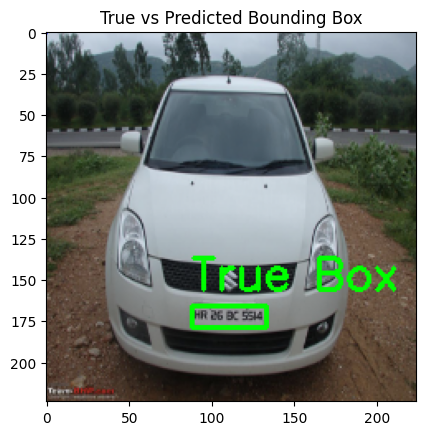

In [44]:
# Plot the bounding boxes on a test image
for i in range(5):  # Just plotting the first 5 images as an example
    plot_image_with_bbox(imgs[i], denorm_box[i], bxs[i])